In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

# 可视化用户画像
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import pandas as pd


In [2]:

# 获取已安装字体的路径
font_path = 'SourceHanSansCN-Regular.otf'

# 创建字体属性对象
font = FontProperties(fname=font_path)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# 创建SparkSession
spark = SparkSession.builder.appName("UserPortrait").getOrCreate()

# 加载用户数据
user_df = spark.read.csv("data/user_data.csv", header=True, inferSchema=True)

# 加载用户行为数据
behavior_df = spark.read.csv("data/user_behavior_data.csv", header=True, inferSchema=True)



23/03/18 01:46:51 WARN Utils: Your hostname, AbeldeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.100 instead (on interface en0)
23/03/18 01:46:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/18 01:46:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [18]:
# 统计用户数据中的记录数量
user_count = user_df.count()

# 统计用户行为数据中的记录数量
behavior_count = behavior_df.count()

# 打印结果
print("用户数据中的记录数量：", user_count)
print("用户行为数据中的记录数量：", behavior_count)


用户数据中的记录数量： 5000
用户行为数据中的记录数量： 100263


<AxesSubplot: >

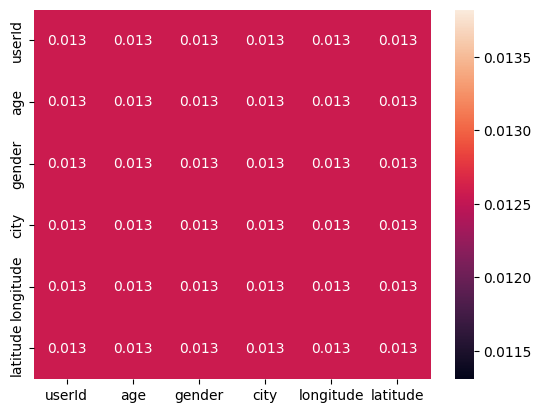

In [15]:
# 计算用户数据中各特征之间的相关系数
corr_matrix = user_df.corr("age", "longitude")



# 将numpy数组转换为DataFrame对象
corr_df = pd.DataFrame(corr_matrix, columns=user_df.columns, index=user_df.columns)

# 绘制相关性矩阵
sns.heatmap(corr_df, annot=True)




In [4]:
# 训练ALS模型，用于商品推荐
# 协同过滤算法
als = ALS(rank=10, maxIter=15, regParam=0.01, userCol="userId", itemCol="itemId", ratingCol="rating")
model = als.fit(behavior_df)

# 针对每个用户生成推荐列表
user_recs = model.recommendForAllUsers(10)

print('#'*20)


23/03/18 01:46:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/18 01:46:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/03/18 01:46:56 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/18 01:46:56 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
####################


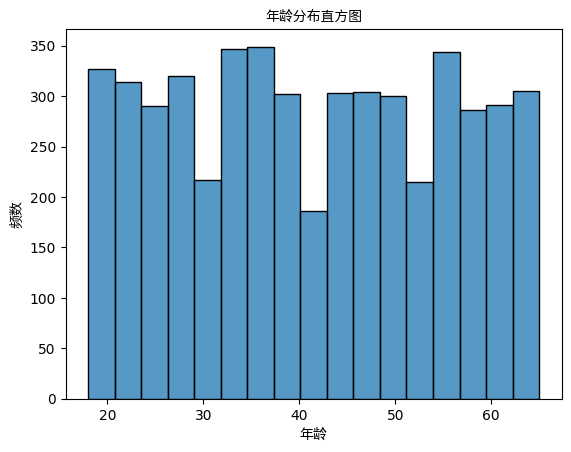

In [5]:
# 将用户画像和推荐结果连接起来
user_recs_with_profile = user_recs.join(user_df, on="userId", how="left")




# 将 PySpark DataFrame 转换为 Pandas DataFrame
user_df_pd = user_df.toPandas()

# 绘制用户年龄分布图
sns.histplot(data=user_df_pd, x="age")


# 绘制用户地理位置云图
# 绘制散点图

plt.xlabel('年龄', fontproperties=font)
plt.ylabel('频数', fontproperties=font)
plt.title('年龄分布直方图', fontproperties=font)
plt.show()





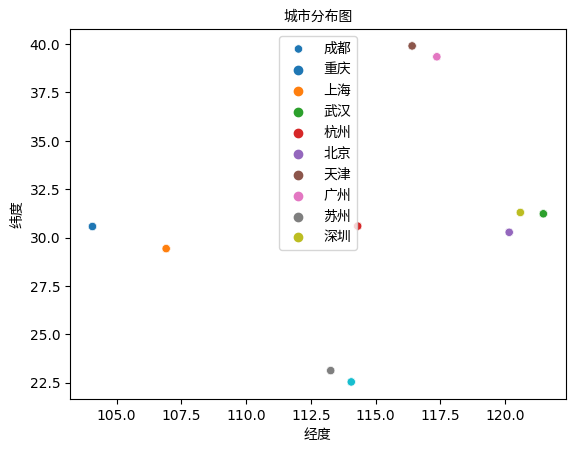

In [6]:
# 绘制用户地理位置云图
sns.scatterplot(data=user_df_pd, x="longitude", y="latitude", hue="city")

# 设置图例字体
current_legend = plt.legend()
plt.legend(title=current_legend.get_title().get_text(), labels=[t.get_text() for t in current_legend.texts], 
           loc=current_legend._loc, prop=font)

# 设置坐标轴标签和标题
plt.xlabel('经度', fontproperties=font)
plt.ylabel('纬度', fontproperties=font)
plt.title('城市分布图', fontproperties=font)

plt.show()


In [7]:

# 生成特征列和标签列
feature_cols = ["age", "longitude", "latitude"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
user_recs_with_profile = assembler.transform(user_recs_with_profile)
user_recs_with_profile = user_recs_with_profile.withColumn("label", 
                                            user_recs_with_profile["gender"].isin(["Male"]).cast("double"))

In [8]:

# 计算用户标签，使用逻辑回归算法
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=0.1, elasticNetParam=0.5)
lr_model = lr.fit(user_recs_with_profile)

# 使用用户画像和推荐结果生成新用户的标签
new_user_df = pd.DataFrame({"userId": [80], "age": [25], "gender": ["Male"],
                            "city": ["上海"], "longitude": [121.4737], "latitude": [31.2304]})
new_user_df = spark.createDataFrame(new_user_df)

new_user_recs = model.recommendForUserSubset(new_user_df, 10)
new_user_recs_with_profile = new_user_recs.join(new_user_df, on="userId", how="left")
new_user_recs_with_profile = assembler.transform(new_user_recs_with_profile)
new_user_recs_with_profile = new_user_recs_with_profile.withColumn("label", 
                                            new_user_recs_with_profile["gender"].isin(["Male"]).cast("double"))

new_user_labels = lr_model.transform(new_user_recs_with_profile)

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [9]:
# 显示用户
print("用户：")
user_df.show()




用户：
+------+---+------+----+---------+--------+
|userId|age|gender|city|longitude|latitude|
+------+---+------+----+---------+--------+
|     0| 27|Female|成都| 104.0665| 30.5728|
|     1| 53|Female|重庆| 106.9123| 29.4316|
|     2| 49|Female|上海| 121.4737| 31.2304|
|     3| 51|Female|重庆| 106.9123| 29.4316|
|     4| 34|Female|武汉| 114.3054| 30.5931|
|     5| 30|  Male|杭州| 120.1551| 30.2741|
|     6| 19|  Male|重庆| 106.9123| 29.4316|
|     7| 21|Female|武汉| 114.3054| 30.5931|
|     8| 33|  Male|上海| 121.4737| 31.2304|
|     9| 19|Female|重庆| 106.9123| 29.4316|
|    10| 58|  Male|北京| 116.4074| 39.9042|
|    11| 41|  Male|天津| 117.3616| 39.3434|
|    12| 30|Female|北京| 116.4074| 39.9042|
|    13| 56|Female|武汉| 114.3054| 30.5931|
|    14| 40|  Male|杭州| 120.1551| 30.2741|
|    15| 53|  Male|北京| 116.4074| 39.9042|
|    16| 28|  Male|天津| 117.3616| 39.3434|
|    17| 60|Female|武汉| 114.3054| 30.5931|
|    18| 49|  Male|天津| 117.3616| 39.3434|
|    19| 45|Female|重庆| 106.9123| 29.4316|
+------+---+------+----+

In [10]:
# 显示推荐结果
print("推荐结果：")
print('user_recs中的recommendations列包含了为每个用户推荐的商品ID及其对应的预测评分')
user_recs_with_profile.show()



推荐结果：
user_recs中的recommendations列包含了为每个用户推荐的商品ID及其对应的预测评分


+------+--------------------+---+------+----+---------+--------+--------------------+-----+
|userId|     recommendations|age|gender|city|longitude|latitude|            features|label|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+
|    26|[{95, 4.5755205},...| 35|Female|天津| 117.3616| 39.3434|[35.0,117.3616,39...|  0.0|
|    27|[{87, 8.926493}, ...| 40|  Male|广州| 113.2644| 23.1291|[40.0,113.2644,23...|  1.0|
|    28|[{39, 5.8753066},...| 63|  Male|杭州| 120.1551| 30.2741|[63.0,120.1551,30...|  1.0|
|    31|[{11, 5.6979103},...| 49|  Male|武汉| 114.3054| 30.5931|[49.0,114.3054,30...|  1.0|
|    34|[{22, 4.1354613},...| 33|  Male|深圳| 114.0579| 22.5431|[33.0,114.0579,22...|  1.0|
|    53|[{34, 4.5294437},...| 29|Female|上海| 121.4737| 31.2304|[29.0,121.4737,31...|  0.0|
|    65|[{11, 7.0896096},...| 52|  Male|成都| 104.0665| 30.5728|[52.0,104.0665,30...|  1.0|
|    76|[{84, 6.0201774},...| 55|Female|重庆| 106.9123| 29.4316|[55.0,106.9123,29...|  0.0|
|   

In [11]:
# 显示标签结果
print("标签结果：")
new_user_labels.show()

标签结果：
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+-------------+----------+
|userId|     recommendations|age|gender|city|longitude|latitude|            features|label|       rawPrediction|  probability|prediction|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+-------------+----------+
|    80|[{36, 7.303678}, ...| 25|  Male|上海| 121.4737| 31.2304|[25.0,121.4737,31...|  1.0|[0.01200014400311...|[0.503,0.497]|       0.0|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+-------------+----------+

